Github link project: https://github.com/BillMousta/ML_Final_Project_Rock_Paper_Scissors_Game

In [ ]:
# import libraries
from google.colab import drive
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter
import cv2
import numpy as np
import random
import warnings
warnings.filterwarnings('ignore')

#Load the dataset and preprocess the data

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def load_dataset(dataset_path='/content/drive/My Drive/ML', apply_normalization=True):
  drive.mount('/content/drive')

  categories = ['rock', 'scissors', 'paper']
  labels = {'rock': 0, 'scissors': 1, 'paper': 2}

  X = []
  y = []

  for category in categories:
      category_path = os.path.join(dataset_path, category)
      for image_name in os.listdir(category_path):
          image_path = os.path.join(category_path, image_name)
          if apply_normalization:
            image = load_img(image_path, target_size=(32, 32), color_mode='grayscale')
            image = img_to_array(image)
            image /= 255.0  # normalize to [0, 1]
          else:
            category_path = os.path.join(dataset_path, category)
            image_name = os.listdir(category_path)[0]
            image_path = os.path.join(category_path, image_name)
            image = load_img(image_path)

          X.append(image)
          y.append(labels[category])

  X = np.array(X)
  y = np.array(y)
  return X, y


In [ ]:
X, y = load_dataset()
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Shape of X: (2188, 32, 32, 1)
Shape of y: (2188,)


# Split data into train/test

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)


Shape of X_train: (1750, 32, 32, 1)
Shape of y_train: (1750,)
Shape of X_test: (438, 32, 32, 1)
Shape of y_test: (438,)


# Class distributions


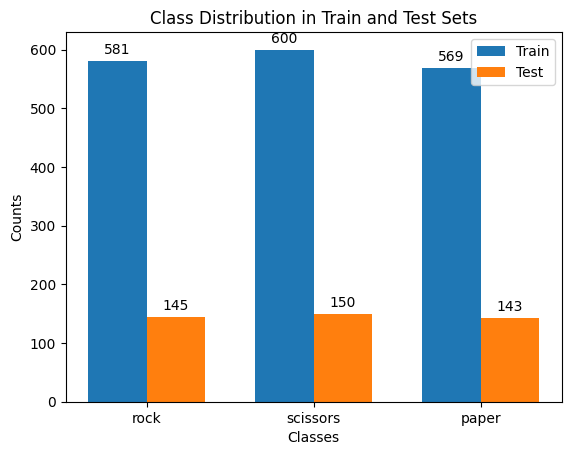

In [ ]:
train_counts = Counter(y_train)
test_counts = Counter(y_test)

# Classes
classes = ['rock', 'scissors', 'paper']

train_data = [train_counts[i] for i in range(len(classes))]
test_data = [test_counts[i] for i in range(len(classes))]

x = np.arange(len(classes))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, train_data, width, label='Train')
rects2 = ax.bar(x + width/2, test_data, width, label='Test')

ax.set_xlabel('Classes')
ax.set_ylabel('Counts')
ax.set_title('Class Distribution in Train and Test Sets')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()

In [ ]:
# Change the labels of y_train y_test for training purposes
def adjust_labels(y):
    return np.array([(label + 2) % 3 for label in y])

y_train_adjusted = adjust_labels(y_train)
y_test_adjusted = adjust_labels(y_test)

# Build the model
The model is a CNN with the following layers:
1. Convolutional Layers: These are the core building blocks of a CNN. They apply a number of filters to the input. Each filter detects different features or patterns in the image, such as edges, textures, or more complex patterns in deeper layers. In your model:

  * The first convolutional layer has 32 filters, each with a kernel size of 3x3.
  * The second convolutional layer has 64 filters, also with a kernel size of 3x3.
2. Activation Function (ReLU): The Rectified Linear Unit (ReLU) activation function is used in your convolutional layers. It introduces non-linearity into the model, allowing it to learn more complex patterns.

3. Max Pooling Layers: These layers reduce the spatial dimensions (width and height) of the input volume for the next convolutional layer. They are used to decrease the computational load, memory usage, and the number of parameters (helping with overfitting). Your model uses pooling layers with a size of 2x2.

4. Flatten Layer: This layer flattens the 2D arrays from pooled feature maps into a single long continuous linear vector. It is used as an input to the fully connected layer.

5. Dense (Fully Connected) Layers: After several convolutional and max pooling layers, the high-level reasoning in the neural network is done via fully connected layers. Neurons in a fully connected layer have connections to all activations in the previous layer. Your model includes:

  * A dense layer with 128 neurons.
  * A final output dense layer with 3 neurons (one for each class: rock, paper, scissors), with a softmax activation function to output probabilities for each class.


# Why It's Good for our Case:
* **Feature Learning:** CNNs are excellent at automatically and adaptively learning spatial hierarchies of features from input images. This is crucial for your task, as the model needs to distinguish between different hand signs.

* **Parameter Efficiency:** Due to the shared weights and local connectivity, CNNs are more efficient compared to fully connected networks, especially for image data. This means you can achieve good performance with relatively fewer parameters.
* **Robustness to Spatial Variations:** CNNs are relatively invariant to the location of features in the input space, making them suitable for image recognition where the object of interest (hand signs in your case) might not be perfectly centered or aligned in all images.

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')  # 3 classes: rock, paper, scissors
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
y_train_categorical = to_categorical(y_train_adjusted, num_classes=3)
y_test_categorical = to_categorical(y_test_adjusted, num_classes=3)

In [ ]:
history = model.fit(X_train, y_train_categorical, epochs=30, validation_data=(X_test, y_test_categorical))


Epoch 1/30
55/55 [==============================] - 8s 53ms/step - loss: 0.8793 - accuracy: 0.6229 - val_loss: 0.6272 - val_accuracy: 0.7831
Epoch 2/30
55/55 [==============================] - 1s 14ms/step - loss: 0.4117 - accuracy: 0.8589 - val_loss: 0.3094 - val_accuracy: 0.8790
Epoch 3/30
55/55 [==============================] - 1s 14ms/step - loss: 0.2471 - accuracy: 0.9194 - val_loss: 0.2410 - val_accuracy: 0.9178
Epoch 4/30
55/55 [==============================] - 0s 8ms/step - loss: 0.1980 - accuracy: 0.9377 - val_loss: 0.1686 - val_accuracy: 0.9475
Epoch 5/30
55/55 [==============================] - 0s 8ms/step - loss: 0.1348 - accuracy: 0.9589 - val_loss: 0.1295 - val_accuracy: 0.9612
Epoch 6/30
55/55 [==============================] - 0s 6ms/step - loss: 0.1157 - accuracy: 0.9634 - val_loss: 0.1709 - val_accuracy: 0.9452
Epoch 7/30
55/55 [==============================] - 0s 5ms/step - loss: 0.1034 - accuracy: 0.9669 - val_loss: 0.1568 - val_accuracy: 0.9384
Epoch 8/30
55/55 

# Build the random Agent

In [ ]:
def select_random_image(X, y):
    index = random.randint(0, len(X) - 1)
    image = X[index]
    label = y[index]
    return image, label

# Example usage
random_image, random_label = select_random_image(X, y)

Random agent's move: scissors, My agent's move: rock
Random agent's move: scissors, My agent's move: rock
Random agent's move: rock, My agent's move: scissors
Random agent's move: paper, My agent's move: scissors
Random agent's move: scissors, My agent's move: rock
Random agent's move: scissors, My agent's move: rock
Random agent's move: paper, My agent's move: scissors
Random agent's move: scissors, My agent's move: rock
Random agent's move: paper, My agent's move: scissors
Random agent's move: scissors, My agent's move: rock


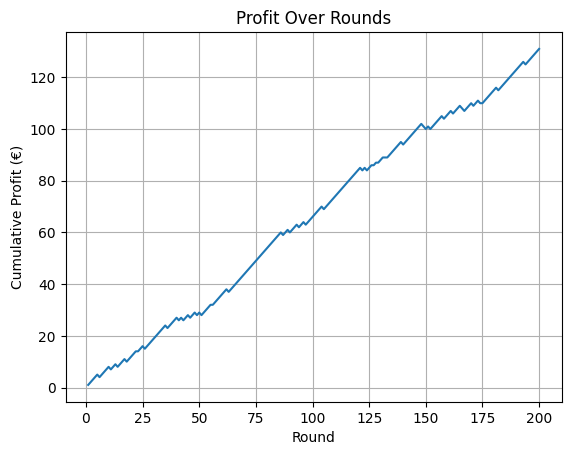

In [ ]:
def preprocess_image(image):
    # Apply vertical flip with probability p1
    if random.random() < 0.5:
        image = cv2.flip(image, 0)

    # Apply horizontal flip with probability p2
    if random.random() < 0.5:
        image = cv2.flip(image, 1)

    noise = np.random.normal(0, 0.05, image.shape)
    image = np.clip(image + noise, 0, 1)

    return image

def calculate_profit(random_agent_move, agent_move):
    if random_agent_move == agent_move:
        return 0  # Tie
    elif (random_agent_move == 0 and agent_move == 2) or \
         (random_agent_move == 1 and agent_move == 0) or \
         (random_agent_move == 2 and agent_move == 1):
        return 1  # Win
    else:
        return -1  # Lose

profit = 0
n_rounds = 200  # Set the number of rounds
profit_tracking = []
lost_rounds = []
game = {0: 'rock', 1: 'scissors', 2: 'paper'}
for i in range(n_rounds):
    # Select a random image and its label
    random_image, random_label = select_random_image(X, y)
    # print(f"The random agent choose: {game[random_label]}")

    processed_image = preprocess_image(random_image)

    processed_image_reshaped = processed_image.reshape(1, 32, 32, 1)

    prediction = model.predict(processed_image_reshaped, verbose=0)
    predicted_label = np.argmax(prediction, axis=1)[0]
    # print(f"the predicted label is: {game[predicted_label]}")

    if i % 20 == 0:
      print(f"Random agent's move: {game[random_label]}, My agent's move: {game[predicted_label]}")

    round_profit = calculate_profit(random_label, predicted_label)
    if round_profit == -1:
      lost_rounds.append(random_label)
    profit += round_profit
    profit_tracking.append(profit)

# Plotting the profit over rounds
plt.plot(range(1, n_rounds + 1), profit_tracking)
plt.title('Profit Over Rounds')
plt.xlabel('Round')
plt.ylabel('Cumulative Profit (€)')
plt.grid(True)
plt.show()


In [ ]:
# Print the labels for the lost rounds for 200 runs
len(lost_rounds)

31

Our agent tends to suffer the most significant losses in the rounds where the random agent opts for 'rock' (indicated by 0). However, it generally outperforms the random agent in the majority of rounds, with a winning probability of approximately 80-85%.

# Test it in other images

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


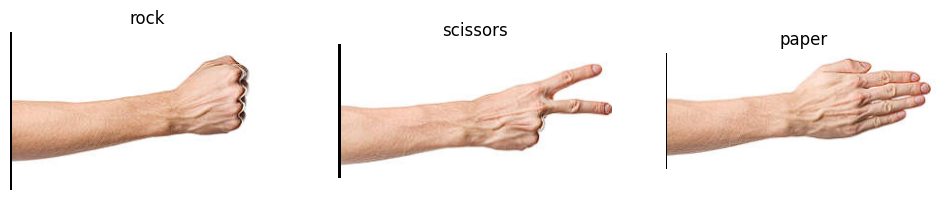

In [ ]:
categories = ['rock', 'scissors', 'paper']

X, y = load_dataset(dataset_path = '/content/drive/My Drive/ML/other', apply_normalization=False)
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, ax in enumerate(axes):
    ax.imshow(X[i], cmap='gray')  # Display in grayscale
    ax.set_title(categories[i])
    ax.axis('off')

plt.show()


In [ ]:
X, y = load_dataset(dataset_path = '/content/drive/My Drive/ML/other', apply_normalization=True)

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Shape of X: (3, 32, 32, 1)
Shape of y: (3,)


# Get model predictions for Web Images
Although our model achieves good results on the testing set within the provided dataset, it struggles to make accurate predictions on real-world images. This discrepancy likely occurs because the distribution of our training dataset does not adequately represent the more complex and varied distribution encountered in real-world scenarios. Consequently, our model underperforms when applied to these web images.

In [ ]:
game = {0: 'rock', 1: 'scissors', 2: 'paper'}
for i, img in enumerate(X):

  processed_image_reshaped = img.reshape(1, 32, 32, 1)
  prediction = model.predict(processed_image_reshaped, verbose=0)
  predicted_label = np.argmax(prediction, axis=1)[0]
  print(f"Enemies move: {game[y[i]]} -> My agent's move: {game[predicted_label]}")


Enemies move: rock -> My agent's move: rock
Enemies move: scissors -> My agent's move: scissors
Enemies move: paper -> My agent's move: scissors
